In [1]:
#!pip install deep_tabular_augmentation
import os
import numpy as np
import torch
from torch import nn
from torch import optim
from sklearn.preprocessing import StandardScaler
from functools import partial
from vpower.src.utils.auxiliary_functions import *
import matplotlib.pyplot as plt

In [ ]:
!pip install numpy==1.23
!pip install tabgan
#!pip freeze


In [2]:
import tabgan
from tabgan.sampler import GANGenerator

In [3]:
data_dir_s =  "../../../data/synthetic_data"
data_dir_r =  "../../../data/real_data"
data_tag="MIX"

In [4]:
# Load data partitions and assign them to dictionary data_all
data_all = {}
for partition in ["train", "dev_in", "dev_out"]:
    df = load_data_and_set_index(filepath=os.path.join(data_dir_s, f"{partition}.csv"), index_column_name="time_id")
    data_all[partition+"_s"] = df
for partition in ["train", "dev_in", "dev_out"]:
    df = load_data_and_set_index(filepath=os.path.join(data_dir_r, f"{partition}.csv"), index_column_name="time_id")
    data_all[partition+"_r"] = df

if data_tag=="RD":
    data_all["train"]=data_all["train_r"]
    data_all["dev_in"]=data_all["dev_in_r"]
else:
    data_all["train"]=   pd.concat([data_all["train_r"], data_all["train_s"]])
    data_all["dev_in"] = pd.concat([data_all["dev_in_r"], data_all["dev_in_s"]])
    
    

In [5]:
input_features = ["draft_aft_telegram",
                  "draft_fore_telegram",

                  "stw",
                  "diff_speed_overground",

                  "awind_vcomp_provider",
                  "awind_ucomp_provider",
                  "rcurrent_vcomp",
                  "rcurrent_ucomp",
                  "comb_wind_swell_wave_height",

                  "timeSinceDryDock",
                  ]

target = "power"

In [6]:
df_x_train = data_all["train"][input_features]
df_x_test = data_all["dev_in"][input_features]
df_y_train = data_all["train"][target]

# Create dataframe versions for tabular GAN
df_x_train = pd.DataFrame(df_x_train)
df_y_train = pd.DataFrame(df_y_train)
df_x_test = pd.DataFrame(df_x_test)


gen_x, gen_y = GANGenerator(gen_x_times=1, cat_cols=None,
           bot_filter_quantile=0.001, top_filter_quantile=0.999, \
              is_post_process=False,
           adversarial_model_params={
               "metrics": "rmse", "max_depth": 2, "max_bin": 100, 
               "learning_rate": 0.02, "random_state": \
                42, "n_estimators": 500,
           }, pregeneration_frac=2, only_generated_data=False,\
           gan_params = {"batch_size": 500, "patience": 25, \
          "epochs" : 250,}).generate_data_pipe(df_x_train, df_y_train,\
          df_x_test, deep_copy=True, only_adversarial=False, \
          use_adversarial=True)

/home/user/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/user/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/user/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds'

In [8]:
gen_y

0          34561.179658
1           1402.915132
2           7229.178354
3           2704.976709
4           6913.806915
               ...     
3161683    13775.000000
3161684    13786.000000
3161685    13716.000000
3161686    26061.000000
3161687    24337.000000
Name: power, Length: 3161688, dtype: float64

In [ ]:
store_path = "models/DA"
torch.save(model.state_dict(), os.path.join(store_path, "da_best_mix_model_v2.pth"))

In [9]:
gen_x.to_csv('gen_x.csv')
gen_x.to_csv('gen_y.csv')

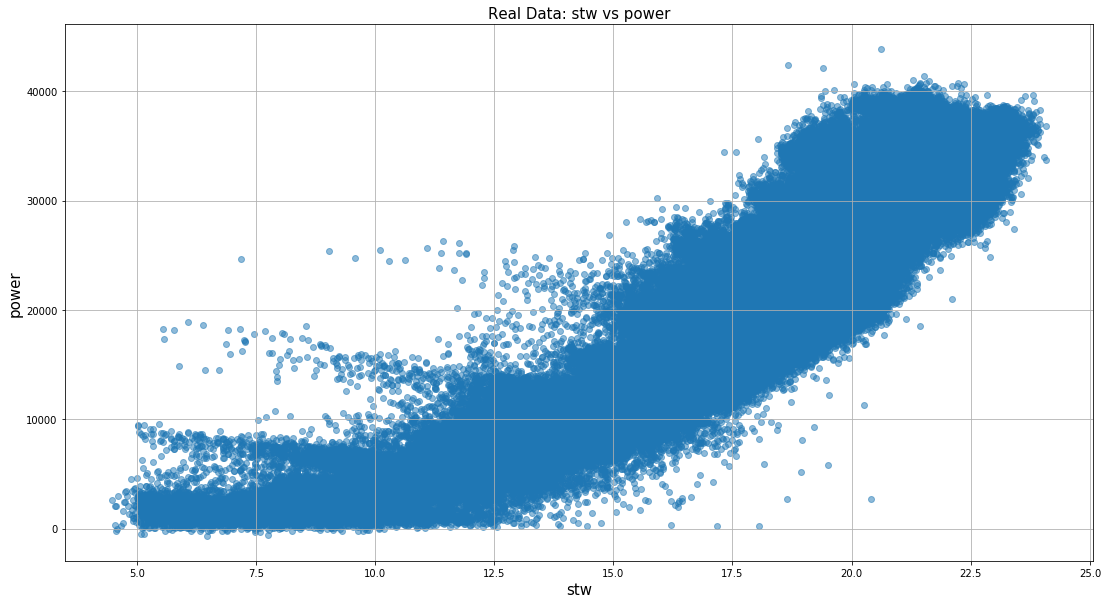

In [11]:
df1=data_all["train"]

fig, ax = plt.subplots()
fig.set_size_inches(15.5, 8.5)
ax.scatter(df1['stw'], df1['power'], alpha=0.5)

ax.set_xlabel('stw', fontsize=15)
ax.set_ylabel('power', fontsize=15)
ax.set_title('Real Data: stw vs power', fontsize=15)

ax.grid(True)
fig.tight_layout()

plt.show()

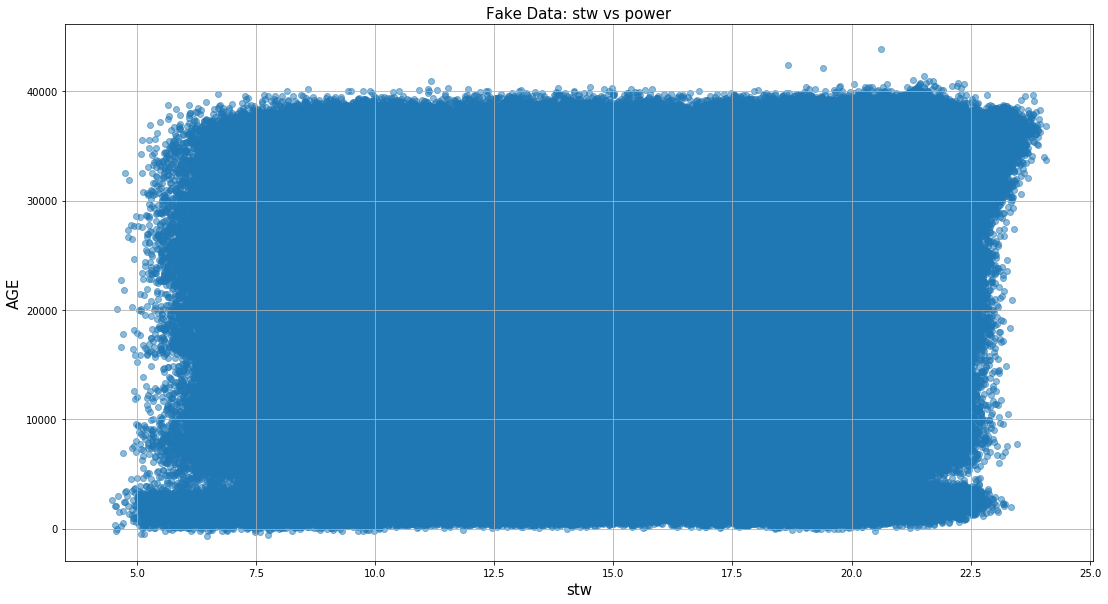

In [12]:
fig, ax = plt.subplots()
fig.set_size_inches(15.5, 8.5)
ax.scatter(gen_x['stw'], gen_y, alpha=0.5)

ax.set_xlabel('stw', fontsize=15)
ax.set_ylabel('Power', fontsize=15)
ax.set_title('Fake Data: stw vs power', fontsize=15)

ax.grid(True)
fig.tight_layout()

plt.show()

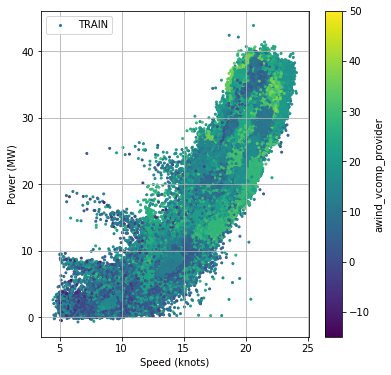

In [16]:
feature_under_study = "awind_vcomp_provider"

plt.figure(figsize=(6, 6))
plt.scatter(df1["stw"], df1["power"] / 1e3,
            c=df1[feature_under_study],
            s=4, label="TRAIN")
plt.legend(loc="upper left")
plt.xlabel("Speed (knots)")
plt.ylabel("Power (MW)")
#plt.xlim(4, 25)
#plt.ylim(-2, 45)
plt.grid()

cbar = plt.colorbar()
cbar.set_label(feature_under_study, rotation=90)
plt.clim(-15, 50)

plt.show()
plt.close()

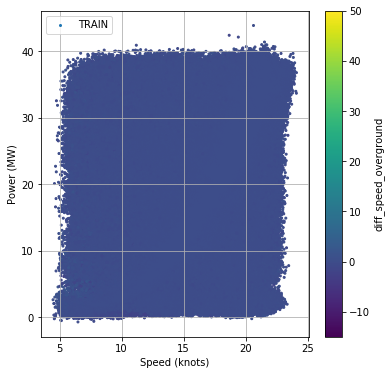

In [15]:
feature_under_study = "diff_speed_overground"

plt.figure(figsize=(6, 6))
plt.scatter(gen_x["stw"],gen_y / 1e3,
            c=gen_x[feature_under_study],
            s=4, label="FAKE")
plt.legend(loc="upper left")
plt.xlabel("Speed (knots)")
plt.ylabel("Power (MW)")
#plt.xlim(4, 25)
#plt.ylim(-2, 45)
plt.grid()

cbar = plt.colorbar()
cbar.set_label(feature_under_study, rotation=90)
plt.clim(-15, 50)

plt.show()
plt.close()